# U.S. Bureau of Labor Statistics API in Python

by Michael T. Moen

*All data retrieved from BLS.gov API. BLS.gov cannot vouch for the data or analyses derived from these data after the data have been retrieved from BLS.gov.*

Please see the following resources for more information on API usage:

- Documentation
    - <a href="https://www.bls.gov/data/" target="_blank">BLS Data Finder</a>
    - <a href="https://www.bls.gov/developers/home.htm" target="_blank">BLS API Documentation</a>
- Terms
    - <a href="https://www.bls.gov/developers/termsOfService.htm" target="_blank">BLS API Terms of Service</a>
- Data Reuse
    - <a href="https://www.bls.gov/bls/linksite.htm" target="_blank">BLS Linking and Copyright Information</a>

**_NOTE:_** Registered users of the BLS API may request up to 500 queries per day. Unregistered Users may request up to 25 queries per day. Additionally, all users are limited to 50 requests per 10 seconds.

*These recipe examples were tested on May 5, 2025.*

## Setup

### Import Libraries

The following external libraries need to be installed into your environment to run the code examples in this tutorial:

- <a href="https://github.com/ipython/ipykernel" target="_blank">ipykernel</a>
- <a href="https://github.com/psf/requests" target="_blank">requests</a>
- <a href="https://github.com/theskumar/python-dotenv" target="_blank">python-dotenv</a>
- <a href="https://github.com/matplotlib/matplotlib" target="_blank">matplotlib</a>

We import the libraries used in this tutorial below:

In [ ]:
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from time import sleep
import json
import math
import os
from dotenv import load_dotenv

### Import Registration Key

Registration is not required to access the BLS API, but it is recommended as it grants higher limits per day and allows users to use the v2.0 API, which is used in this tutorial. You can sign up for one at the <a href="https://data.bls.gov/registrationEngine/" target="_blank">BLS website</a>.

We keep our API key in a `.env` file and use the `dotenv` library to access it. If you would like to use this method, create a `.env` file and add the following line to it:

```text
BLS_API_KEY=PUT_YOUR_API_KEY_HERE
```

In [3]:
load_dotenv()
try:
    API_KEY = os.environ["BLS_API_KEY"]
except KeyError:
    print("API key not found. Please set 'BLS_API_KEY' in your .env file.")

## 1. Find the Average Price of Eggs Over Time

The endpoints of the BLS API are found using the Series ID of the specific dataset. These series IDs can be found <a href="https://www.bls.gov/data/" target="_blank">here</a>. 

Below, we'll build a POST request for the API to find the average price of a dozen eggs each month from 2020 through September 2023.

In [9]:
URL = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# Series ID for average price of 'Eggs, grade A, large, per dozen'
series_id = ['APU0000708111']

# The BLS API accepts a max of a 20 year span per request, and bounds are inclusive
start_year = '2020'
end_year = '2025'

headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": series_id,
                   "startyear": start_year,
                   "endyear": end_year,
                   "registrationkey": API_KEY})

response = requests.post(URL, headers=headers, data=data)

# Status code 200 indicates success
response.status_code

200

In [11]:
data = response.json()['Results']['series'][0]['data']

# Display number of results retrieved
len(data)

63

In [12]:
# Display first 3 results
data[:3]

[{'year': '2025',
  'period': 'M03',
  'periodName': 'March',
  'latest': 'true',
  'value': '6.227',
  'footnotes': [{}]},
 {'year': '2025',
  'period': 'M02',
  'periodName': 'February',
  'value': '5.897',
  'footnotes': [{}]},
 {'year': '2025',
  'period': 'M01',
  'periodName': 'January',
  'value': '4.953',
  'footnotes': [{}]}]

Now, we'll format the data above so that we can plot it with the matplotlib library:

In [ ]:
# Store average price of eggs in (date, value) tuples
monthly_prices = []

for data_point in data:
    
    # Convert date to datetime object for compatibility with matplotlib
    date = f"{data_point['period'][1:]}/{data_point['year']}"
    date = dt.datetime.strptime(date,'%m/%Y').date()
    
    value = float(data_point['value'])
    
    monthly_prices.append((date, value))

# Display first 12 results
monthly_prices[:12]

[(datetime.date(2025, 3, 1), 6.227),
 (datetime.date(2025, 2, 1), 5.897),
 (datetime.date(2025, 1, 1), 4.953),
 (datetime.date(2024, 12, 1), 4.146),
 (datetime.date(2024, 11, 1), 3.649),
 (datetime.date(2024, 10, 1), 3.37),
 (datetime.date(2024, 9, 1), 3.821),
 (datetime.date(2024, 8, 1), 3.204),
 (datetime.date(2024, 7, 1), 3.08),
 (datetime.date(2024, 6, 1), 2.715),
 (datetime.date(2024, 5, 1), 2.699),
 (datetime.date(2024, 4, 1), 2.864)]

Now, we can graph the data in matplotlib:

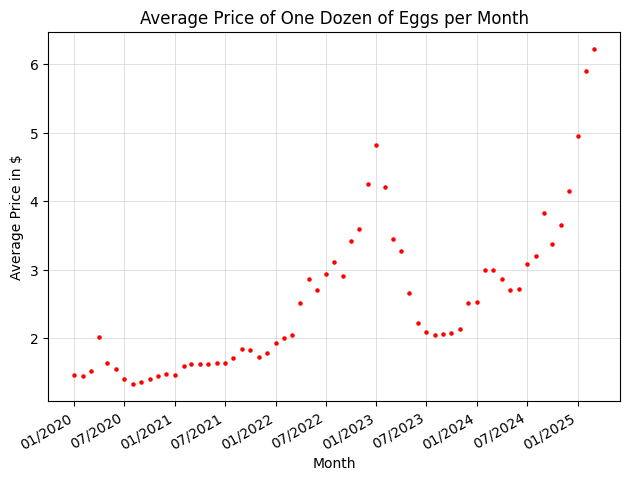

In [16]:
# Convert list of tuples into 2 separate lists of dates and prices
dates, prices = zip(*monthly_prices)

fig, ax = plt.subplots()
ax.set_ylabel("Average Price in $")
ax.scatter(dates, prices, s=5, color="red")
ax.tick_params(axis='y')

fig.tight_layout()
ax.set_xlabel("Month")
plt.title("Average Price of One Dozen of Eggs per Month")
ax.grid(linewidth=0.5, color='lightgray')
ax.set_axisbelow(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.gcf().autofmt_xdate()

plt.show()

## 2. Find the Average Prices of Multiple Items

The BLS API allows users to query up to 25 series in a single request. Below, we'll obtain the series data for multiple common household goods in a single request:

In [17]:
# Series IDs for a variety of common groceries
series_ids = {'APU0000708111': 'eggs (doz)',
              'APU0000709112': 'whole milk (gal)',
              'APU0000717311': 'coffee grounds (lb)',
              'APU0000706111': 'whole chicken (lb)',
              'APU0000704111': 'sliced bacon (lb)',
              'APU0000701111': 'all purpose white flour (lb)',
              'APU0000710411': 'ice cream (1/2 gal)',
              'APU0000703112': 'ground beef (lb)',
              'APU0000711211': 'bananas (lb)',
              'APU0000701312': 'white rice (uncooked lb)',
              'APU0000712311': 'tomatoes (lb)',
              'APU0000703613': 'sirloin steak (lb)'}

# The BLS API accepts a max of a 20 year span per request, and bounds are inclusive
start_year = '2020'
end_year = '2025'

headers = {'Content-type': 'application/json'}
data = json.dumps({"seriesid": list(series_ids.keys()),
                   "startyear": start_year,
                   "endyear": end_year,
                   "registrationkey": API_KEY})

data_retrieved = requests.post(URL, headers=headers, data=data).json()['Results']['series']

# Display number of series obtained
len(data_retrieved)

12

In [18]:
number_of_items = len(series_ids) + 1

monthly_prices = [[0] * number_of_items]
monthly_prices[0][0] = 'date'

for i in data_retrieved[0]['data']:
    
    monthly_prices.append([0] * number_of_items)
    date = f"{i['period'][1:]}/{i['year']}"
    monthly_prices[-1][0] = date

for i, item in enumerate(data_retrieved):
    
    item_name = series_ids[item['seriesID']]
    monthly_prices[0][i+1] = item_name
    
    for j, data_point in enumerate(item['data']):
        
        value = float(data_point['value'])
        monthly_prices[j+1][i+1] = value

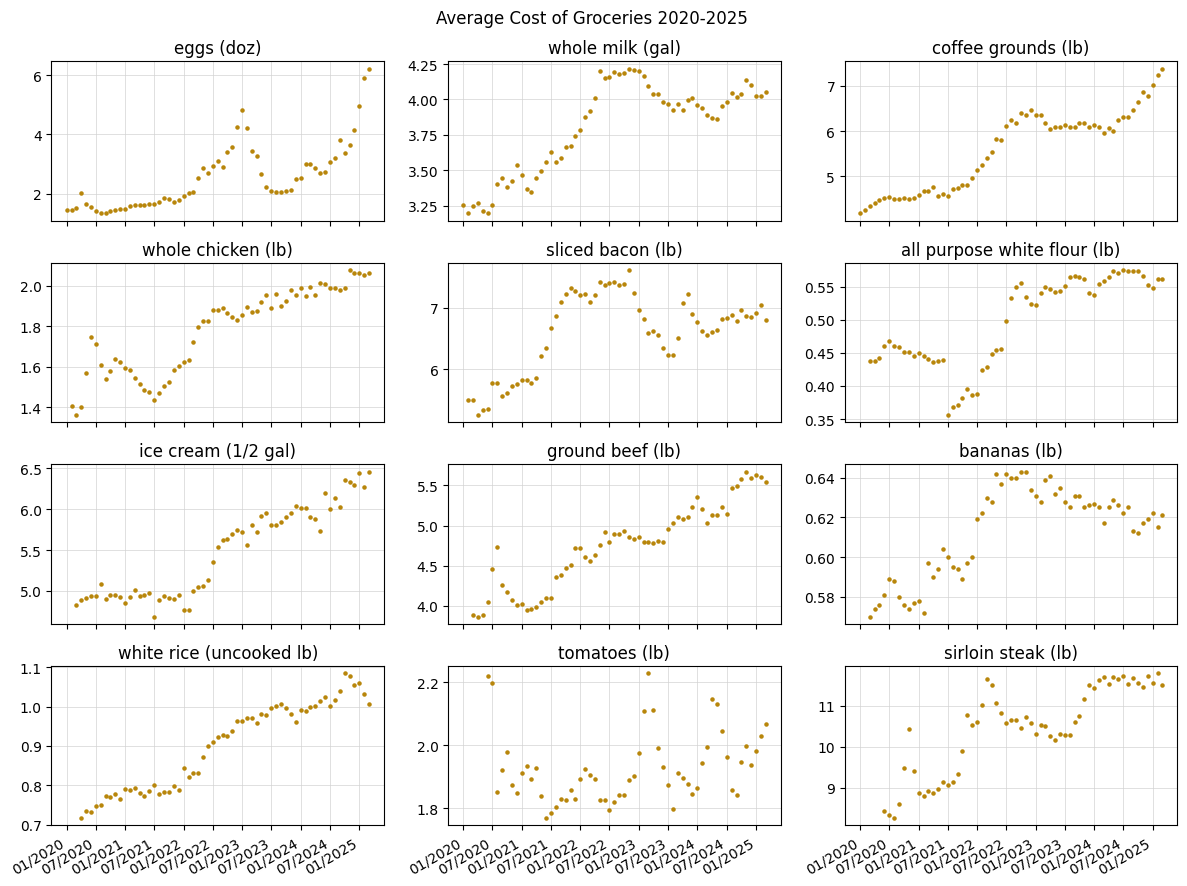

In [21]:
fig, axs = plt.subplots(4, 3, figsize=(12, 9), sharex=True)
fig.suptitle('Average Cost of Groceries 2020-2025')

dates = [dt.datetime.strptime(row[0], '%m/%Y').date() for row in reversed(monthly_prices[1:])]

for i in range(12):
    x = i // 3  # x-coordinate of graph (row number)
    y = i % 3   # y-coordinate of graph (column number)
    
    prices = [row[i+1] for row in reversed(monthly_prices[1:])]
    
    # Filter out data points where price is 0
    valid_data = [(date, price) for date, price in zip(dates, prices) if price != 0]
    dates, prices = zip(*valid_data)
    
    axs[x, y].scatter(dates, prices, s=5, color='darkgoldenrod')
    axs[x, y].set_title(monthly_prices[0][i+1])
    
    axs[x, y].xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
    axs[x, y].xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    fig.autofmt_xdate()
    
    axs[x, y].grid(linewidth=0.5, color='lightgray')
    axs[x, y].set_axisbelow(True)

plt.tight_layout()

plt.show()

## 3. Find Yearly Earnings 1979-2023

For this example, we'll look at the earnings published by the BLS.

Since the span of years in this dataset is greater than 20, we'll first create a function to split up a given year interval into a list of intervals no greater than 20 years in length:

In [33]:
# Returns a list of tuples containing (start_year, end_year) intervals no greater than 20 years
# apart, since that is the maximum span allowed in a single API request
def generate_year_intervals(start, end):
    
    intervals = []
    
    while start <= end:
        if start + 19 < end:
            intervals.append((str(start), str(start+19)))
        else:
            intervals.append((str(start), str(end)))
        start += 20
        
    return intervals

Now, we can make a series of API requests over this interval.

In [39]:
# Series ID for '(unadj)- Median usual weekly earnings (second quartile), Employed full time,
# Wage and salary workers'
series_ids = ['LEU0252881500']

# Starting and ending bounds for the data we want to retrieve
start = 1979
end = 2025

intervals = generate_year_intervals(start, end)
headers = {'Content-type': 'application/json'}
data_retrieved = []

for interval in intervals:
    data = json.dumps({"seriesid": series_ids,
                       "startyear": interval[0],
                       "endyear": interval[1],
                       "registrationkey": API_KEY})
    response = requests.post(URL, headers=headers, data=data)

    # Combine the lists returned from each query into a single list
    data_retrieved.extend(response.json()['Results']['series'][0]['data'])

    # Wait 0.2 seconds between API calls to conform to the rate limits
    sleep(0.2)

# Display length of data
len(data_retrieved)

185

In [40]:
# Display first 3 results
data_retrieved[:3]

[{'year': '1998',
  'period': 'Q04',
  'periodName': '4th Quarter',
  'value': '541',
  'footnotes': [{}]},
 {'year': '1998',
  'period': 'Q03',
  'periodName': '3rd Quarter',
  'value': '520',
  'footnotes': [{}]},
 {'year': '1998',
  'period': 'Q02',
  'periodName': '2nd Quarter',
  'value': '515',
  'footnotes': [{}]}]

Now, let's format the data to be graphed.

In [42]:
# Store yearly earnings in (date, earnings) tuples
yearly_earnings = []

for data_point in data_retrieved:
    
    if data_point['period'] != 'Q01':
        continue
    
    # Put date in MM/YYYY notation and convert date to datetime object for compatibility with matplotlib
    date = f"01/{data_point['year']}"
    date = dt.datetime.strptime(date,'%m/%Y').date()
    
    # Multiply weekly earnings by 52 to approximate the salary
    salary = float(data_point['value']) * 52
    
    yearly_earnings.append((date, salary))

# Display first 5 results
yearly_earnings[:5]

[(datetime.date(1998, 1, 1), 27092.0),
 (datetime.date(1997, 1, 1), 26208.0),
 (datetime.date(1996, 1, 1), 25428.0),
 (datetime.date(1995, 1, 1), 24856.0),
 (datetime.date(1994, 1, 1), 24388.0)]

Now, let's graph this data with a scatter plot.

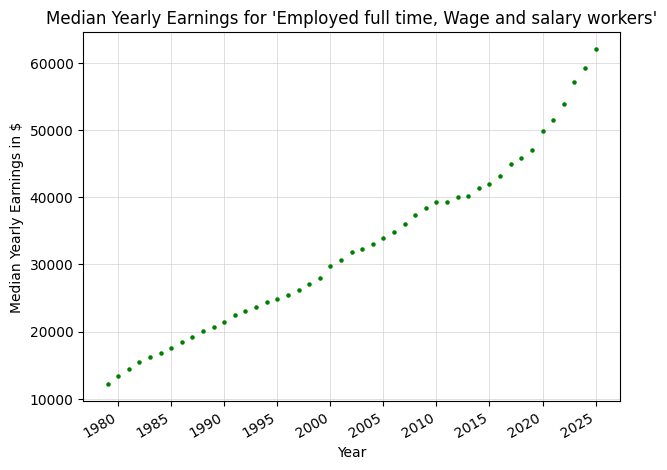

In [43]:
# Convert list of tuples into 2 separate lists of dates and prices
dates, salaries = zip(*yearly_earnings)

fig, ax = plt.subplots()
ax.set_ylabel("Median Yearly Earnings in $")
ax.scatter(dates, salaries, s=5, color="green")
ax.tick_params(axis='y')

fig.tight_layout()
ax.set_xlabel("Year")
plt.title("Median Yearly Earnings for 'Employed full time, Wage and salary workers'")
ax.grid(linewidth=0.5, color='lightgray')
ax.set_axisbelow(True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
plt.gcf().autofmt_xdate()

plt.show()

## 4. Finding the Unemployment Rate 1948-2023

For our final example, we'll graph the unemployment rate going back to 1948.

In [45]:
# Series ID for unemployment Rate
series_ids = ['LNS14000000']

# The BLS API accepts a max of a 20 year span per request, and bounds are inclusive
start = 1948
end = 2025

intervals = generate_year_intervals(start, end)
headers = {'Content-type': 'application/json'}
data_retrieved = []

for interval in intervals:
    data = json.dumps({"seriesid": series_ids,
                       "startyear": interval[0],
                       "endyear": interval[1],
                       "registrationkey": API_KEY})
    response = requests.post(URL, headers=headers, data=data)

    # Combine the lists returned from each query into a single list
    data_retrieved.extend(response.json()['Results']['series'][0]['data'])
    
    # Wait 0.2 seconds between API calls to conform to the rate limits
    sleep(0.2)

# Dsipaly length of data
len(data_retrieved)

928

In [46]:
# Display 3 data entries
data_retrieved[:3]

[{'year': '1967',
  'period': 'M12',
  'periodName': 'December',
  'value': '3.8',
  'footnotes': [{}]},
 {'year': '1967',
  'period': 'M11',
  'periodName': 'November',
  'value': '3.9',
  'footnotes': [{}]},
 {'year': '1967',
  'period': 'M10',
  'periodName': 'October',
  'value': '4.0',
  'footnotes': [{}]}]

Now, let's format and filter the data returned from the API request for graphing.

For this graph, we'll only consider the unemployment rates reported in January, April, July, and October.

In [47]:
# Store the unemployment rate data in (date, rate) tuples
unemployment_rates = []

for data_point in data_retrieved:
    
    # Filter out months other than January, April, July, and October
    if data_point['period'] not in ['M01', 'M04', 'M07', 'M10']:
        continue
    
    # Put date in MM/YYYY notation and convert date to datetime object for compatibility with matplotlib
    date = f"{data_point['period'][1:]}/{data_point['year']}"
    date = dt.datetime.strptime(date,'%m/%Y').date()
    
    rate = float(data_point['value'])
    
    unemployment_rates.append((date, rate))

# Display first 5 results
unemployment_rates[:5]

[(datetime.date(1967, 10, 1), 4.0),
 (datetime.date(1967, 7, 1), 3.8),
 (datetime.date(1967, 4, 1), 3.8),
 (datetime.date(1967, 1, 1), 3.9),
 (datetime.date(1966, 10, 1), 3.7)]

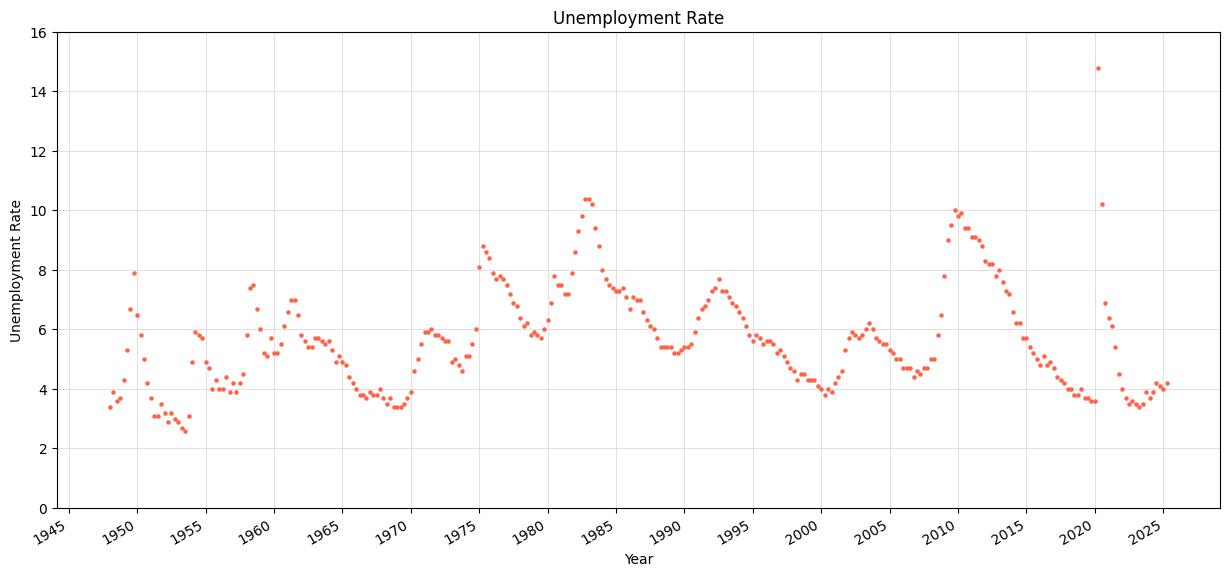

In [48]:
# Convert list of tuples into 2 separate lists of dates and unemployment rates
dates, rates = zip(*unemployment_rates)

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(dates, rates, s=5, color="tomato", label="Unemployment Rate")
ax.set_ylabel("Unemployment Rate")
ax.grid(linewidth=0.5, color='lightgray')
ax.set_axisbelow(True)
ax.set_ylim(0, math.ceil(max(rates)) + 1)

plt.title("Unemployment Rate")
plt.xlabel("Year")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
plt.gcf().autofmt_xdate()

plt.show()